In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [4]:
stop_sign_dir = '/content/drive/MyDrive/MSE_2024/MSE_Data/Stop'
priority_sign_dir = '/content/drive/MyDrive/MSE_2024/MSE_Data/Priority'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(224, 224))
        if img is not None:
            images.append(tf.keras.preprocessing.image.img_to_array(img))
    return np.array(images)

stop_sign_images = load_images_from_folder(stop_sign_dir)
priority_sign_images = load_images_from_folder(priority_sign_dir)

# Create labels
stop_sign_labels = np.zeros(stop_sign_images.shape[0])
priority_sign_labels = np.ones(priority_sign_images.shape[0])

# Combine the data
images = np.concatenate((stop_sign_images, priority_sign_images), axis=0)
labels = np.concatenate((stop_sign_labels, priority_sign_labels), axis=0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
9/9 [==============================] - 25s 2s/step - loss: 1.1300 - accuracy: 0.6591 - val_loss: 0.5106 - val_accuracy: 0.6930
Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.3518 - accuracy: 0.8561 - val_loss: 0.1306 - val_accuracy: 0.9386
Epoch 3/10
9/9 [==============================] - 17s 2s/step - loss: 0.1840 - accuracy: 0.9205 - val_loss: 0.0930 - val_accuracy: 0.9649
Epoch 4/10
9/9 [==============================] - 17s 2s/step - loss: 0.1546 - accuracy: 0.9280 - val_loss: 0.0846 - val_accuracy: 0.9737
Epoch 5/10
9/9 [==============================] - 17s 2s/step - loss: 0.1343 - accuracy: 0.9545 - val_loss: 0.0540 - val_accuracy: 0.9912
Epoch 6/10
9/9 [==============================] - 17s 2s/step - loss: 0.1101 - accuracy: 0.9659 - val_loss: 0.0539 - val_accuracy: 0.9825
Epoch 7/10
9/9 [==============================] - 17s 2s/step - loss: 0.1105 - accuracy: 0.9470 - val_loss: 0

In [7]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


4/4 [==============================] - 5s 1s/step - loss: 0.0339 - accuracy: 0.9825
Validation Accuracy: 98.25%


In [8]:
model.save('/content/drive/MyDrive/CSV_Files/stop_priority_sign_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


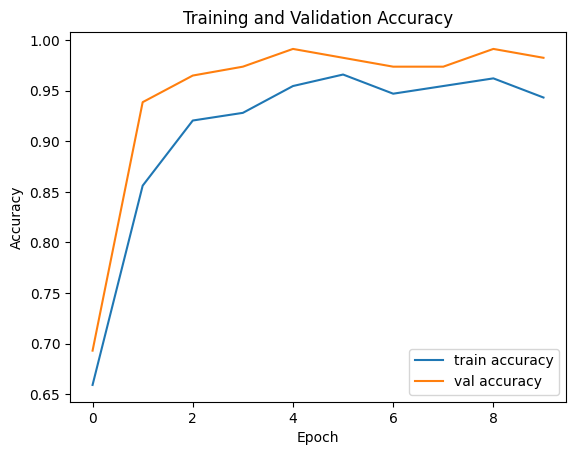

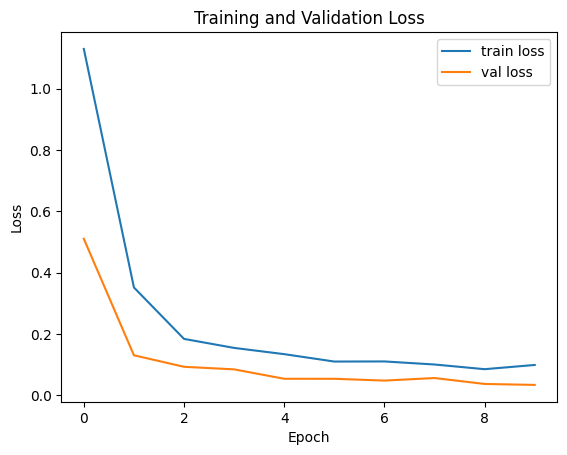

In [10]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 [==============================] - 1s 1s/step
The predicted label for the given image is: Stop sign


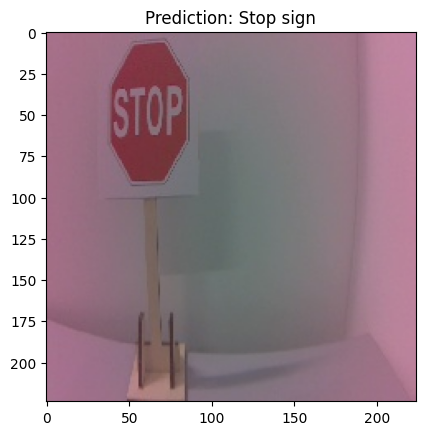

In [12]:
# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/CSV_Files/stop_priority_sign_classifier.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image array
    return img_array

def predict_sign(img_path, model):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)

    if prediction < 0.5:
        return "Stop sign"
    else:
        return "Priority sign"

# Path to the test image
test_image_path = '/content/drive/MyDrive/MSE_2024/MSE_Data/Stop/001066ca-ed96-11ed-926d-a46bb6069316.jpg'

# Predict the label of the test image
predicted_label = predict_sign(test_image_path, model)

print(f'The predicted label for the given image is: {predicted_label}')

#Display the image with the prediction result
img = image.load_img(test_image_path)
plt.imshow(img)
plt.title(f'Prediction: {predicted_label}')
plt.show()
